# Efficiency from SSM

## Tutorial that shows how to use GW_models.py and hydro_bubbles.py to compute the efficiency of GW production according to the sound-shell model.

### It follows the assumptions presented in HH19: *Hindmarsh & Hijazi*, JCAP 12 (2019) 062, arXiv:1909.10040, see Appendix B of RPPC23: Roper Pol et al., Phys. Rev. D 109 (2024) 6, 063531, arXiv:2308.12943 for details

### Created by Alberto Roper Pol (alberto.roperpol@unige.ch), 29/08/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
HOME = os.getcwd()

os.chdir('../..')
import plot_sets
import hydro_bubbles as hb
import GW_models
os.chdir(HOME)

# reference values
cs2 = 1/3
cs = np.sqrt(cs2)

# reference colors
cols = hb.cols_ref

3 iterations for vw= 0.1  and alpha=  0.1
alpha: 0.10000056084045662 , alpha_+: 0.09813185769839378
4 iterations for vw= 0.18888888888888888  and alpha=  0.1
alpha: 0.09999900181946568 , alpha_+: 0.09411323323662565
6 iterations for vw= 0.2777777777777778  and alpha=  0.1
alpha: 0.09999982946398256 , alpha_+: 0.08842188639974843
7 iterations for vw= 0.3666666666666667  and alpha=  0.1
alpha: 0.10000048977769864 , alpha_+: 0.0810772284336778
9 iterations for vw= 0.4555555555555556  and alpha=  0.1
alpha: 0.1000002560673211 , alpha_+: 0.07178651848122784
10 iterations for vw= 0.5444444444444445  and alpha=  0.1
alpha: 0.09999969586033286 , alpha_+: 0.060193337005230836
9 iterations for vw= 0.6333333333333333  and alpha=  0.1
alpha: 0.10000093248966695 , alpha_+: 0.046917468619858516
9 iterations for vw= 0.7222222222222222  and alpha=  0.1
alpha: 0.10000039446118626 , alpha_+: 0.034197337618681996


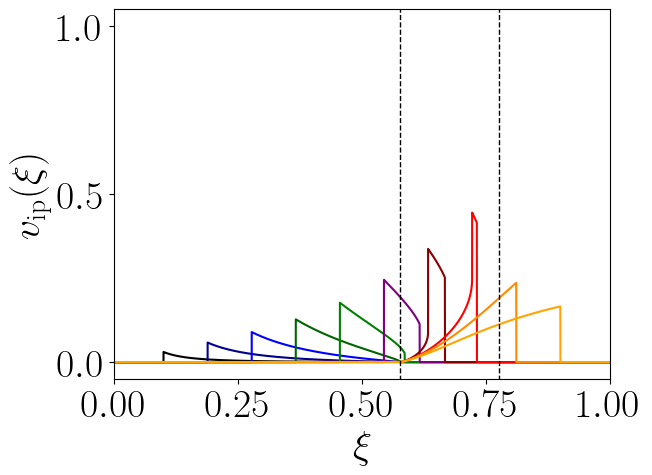

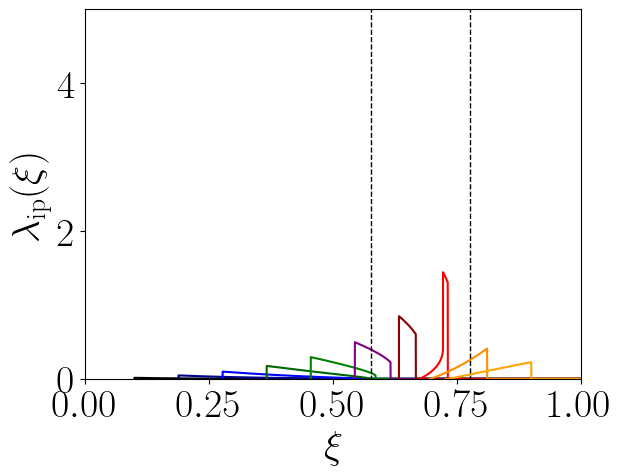

In [22]:
### compute the 1d profiles of the fluid perturbations

## we first compute the 1d profiles (velocity and energy fluctuations lambda)
## for a chosen alpha and range of vws

alpha = 0.1
#vws = np.linspace(0.32, .8, 13)
vws = np.linspace(0.1, .9, 10)
# define string of vws for saving file
#str_vws = ['032', '036', '04', '044', '048', '052', '056', '06', '064', '068', '072', '076', '08']
#str_alp = '00046'
Nxi = 6000

xis, vvs, lams, alphapl, conv, shocks, xifs, wms, kappas, omegas = \
       hb.compute_profiles_vws(alpha, vws=vws, cs2=cs2, plot=True, plot_v='both', cols=[], meth=2,
                               alphan=True, lam=True, eff=True, quiet=True, tol=1e-5, max_it=30, Nxi=Nxi, Nxi2=2*Nxi,
                               save=False)

types = hb.type_nucleation(vws, alpha, cs2=cs2)

In [23]:
# we now compute the f'2 function from the 1d profiles that will be used to compute
# the kinetic spectrum

Nz = 1000
z_min = -2
z_max = 6
z = np.logspace(z_min, z_max, Nz)
fpzs, lzs = hb.fp_z(xis, vvs, z, ls=lams, multi=True, quiet=False, lz=True)

vw  1 / 10  computed
vw  2 / 10  computed
vw  3 / 10  computed
vw  4 / 10  computed
vw  5 / 10  computed
vw  6 / 10  computed
vw  7 / 10  computed
vw  8 / 10  computed
vw  9 / 10  computed
vw  10 / 10  computed


In [45]:
# compute power spectral density as a function of q/beta using the sound-shell model
# and exponential nucleation

Nqbeta = 2000

q_beta, Pv_exp = GW_models.compute_kin_spec_dens(z, vws, fpzs, lzs, sp='sum', type_n='exp', cs2=cs2,
                                  min_qbeta=-3, max_qbeta=4, Nqbeta=Nqbeta,
                                  min_TT=-1, max_TT=3, NTT=5000)

q_beta_sim, Pv_sim = GW_models.compute_kin_spec_dens(z, vws, fpzs, lzs, sp='sum', type_n='sim', cs2=cs2,
                                  min_qbeta=-3, max_qbeta=4, Nqbeta=Nqbeta,
                                  min_TT=-1, max_TT=3, NTT=5000)

In [46]:
## compute the spectrum EK and kR in terms of the power spectral density Pv and q/beta

kks, EK_exp = GW_models.compute_kin_spec(vws, q_beta, Pv_exp, corr=False, cs2=cs2)
kks, EK_sim = GW_models.compute_kin_spec(vws, q_beta_sim, Pv_sim, corr=False, cs2=cs2)

exp 0.1 0.002701419303739214 2.830103807632918
sim 0.1 0.0018390098199377023 4.155119053384096
exp 0.2 0.0026645425761251023 3.000792714671005
sim 0.2 0.0019559489062358276 4.085552664837372
exp 0.3 0.0023751680284177642 3.601492003320342
sim 0.3 0.0017756810027942968 4.8140568343606125
exp 0.4 0.00191516226458953 4.902627195502811
sim 0.4 0.0014000903793781746 6.700368337301951
exp 0.5 0.0013983873275495503 7.60853818156167
sim 0.5 0.0010007620131447055 10.618501373389263
exp 0.5 0.0009077159568773884 13.70331209967452
sim 0.5 0.000647521507707871 19.162205651371867
exp 0.6 0.0005528560214136238 24.584176416284503
sim 0.6 0.0003978426575550735 34.021443803138375
exp 0.7 0.0004403537708605656 24.64765874820912
sim 0.7 0.0003169854528292717 33.773814851141964
exp 0.8 0.0005342862475521465 10.256524756395626
sim 0.8 0.0003807209362510783 14.359867003547766
exp 0.9 0.0005035587472178513 7.6045385978710796
sim 0.9 0.0003607613457152258 10.60070798611795


/var/folders/b6/3r0yh3x54_5cs19wp0cphr7r0000gn/T/ipykernel_8816/2257072168.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  KK_exp[i] = np.trapz(EK_exp[i, inds], kks[i, inds])/maxEK_exp[i]
/var/folders/b6/3r0yh3x54_5cs19wp0cphr7r0000gn/T/ipykernel_8816/2257072168.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  KK_sim[i] = np.trapz(EK_sim[i, inds], kks[i, inds])/maxEK_sim[i]


(0.001, 8000.0)

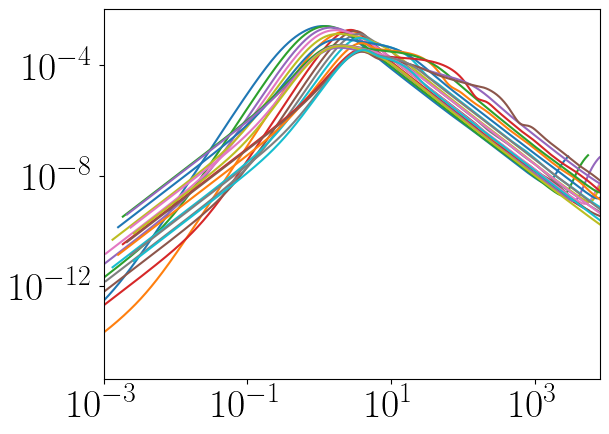

In [48]:
KK_exp = np.zeros(len(vws))
KK_sim = np.zeros(len(vws))

maxEK_exp = np.zeros(len(vws))
maxEK_sim = np.zeros(len(vws))

for i in range(0, len(vws)):
    plt.plot(kks[i, :], EK_exp[i, :])
    plt.plot(kks[i, :], EK_sim[i, :])
    maxEK_exp[i] = max(EK_exp[i, :])
    maxEK_sim[i] = max(EK_sim[i, :])
    inds = np.where(kks[i, :] < 1e3)[0]
    KK_exp[i] = np.trapz(EK_exp[i, inds], kks[i, inds])/maxEK_exp[i]
    KK_sim[i] = np.trapz(EK_sim[i, inds], kks[i, inds])/maxEK_sim[i]
    print('exp', '%.1f'%vws[i], maxEK_exp[i], KK_exp[i])
    print('sim', '%.1f'%vws[i], maxEK_sim[i], KK_sim[i])
plt.loglog()
plt.xlim(1e-3, 8e3)

In [7]:
#### computation of the GW efficiency under the assumptions taken in HH19,
#### corrected in RPPC23, and described in App. B of RPPC23

Nk = 120
Np = 3000

# OmGW^HH(k) = (3pi)/8cs x (k/kst)^2 x (K/KK)^2 x TGW x Omm(k)

zetaGW_HH = np.zeros((len(vws), Nk))
OmGW_HH = np.zeros((len(vws), Nk))
Omtilde_HH = np.zeros(len(vws))
kps = np.zeros((len(vws), Nk))
    
for i in range(0, len(vws)):

    zeta_EK = EK_exp[i, :]/max(EK_exp[i, :])
    KK = np.trapz(zeta_EK, kks[i, :])
    kps[i, :], OmGW_HH[i, :] = GW_models.OmGW_ssm_HH19(kks[i, :], zeta_EK, Np=Np, Nk=Nk, plot=False, cs2=cs2)
    
    zetaGW_HH[i, :] = np.pi/8*kps[i, :]**2/cs*OmGW_HH[i, :]/KK**2
    Omtilde_HH[i] = np.trapz(zetaGW_HH[i, :], np.log(kps[i, :]))

Text(0.5, 1.0, '$\\alpha = 0.0046$')

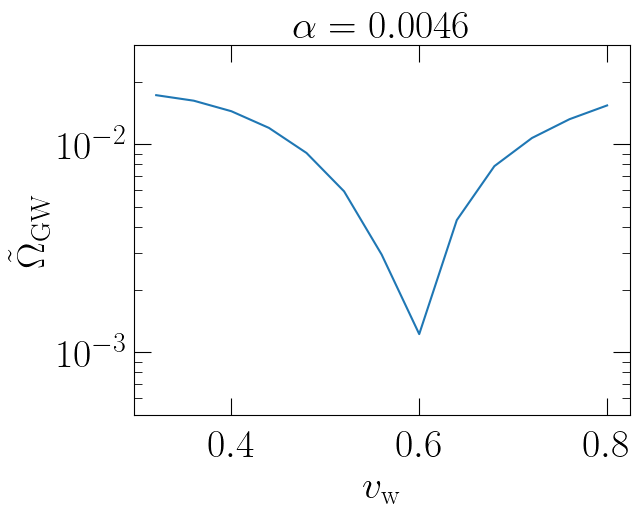

In [12]:
### We can now plot the efficiency Omega_tilde vs vw

plt.plot(vws, Omtilde_HH)
plt.yscale('log')
plot_sets.axes_lines()

plt.ylim(5e-4, 3e-2)
plt.xlabel(r'$v_{\rm w}$')
plt.ylabel(r'$\tilde \Omega_{\rm GW}$')
plt.title(r'$\alpha = 0.0046$')